In this lab, we will learn how to implement k-means and EM, and visualize some essential differences. Let us start with some synthetic data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400,centers=4,cluster_std=2,random_state=10)

(-11.02535175761933,
 11.24746483124909,
 -16.848150742263016,
 11.839765378970164)

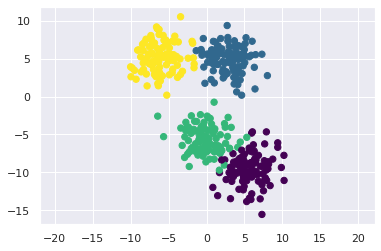

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis');
ax = plt.gca()
ax.axis('equal')

OK, let's now run KMeans.

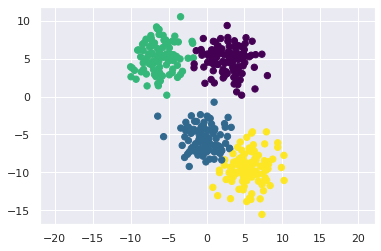

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(4)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
ax = plt.gca()
ax.axis('equal')
plt.show();

The first issue in k-means is that it does *hard* clustering: points at the borders between clusters get somewhat arbitrarily assigned, and there is no way to declare low cluster confidence. The seond issue is that clusters are necessarily circular/spherical. 

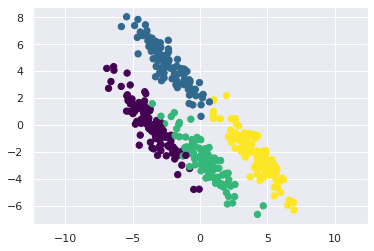

In [5]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=y_true, s=40, cmap='viridis');
ax = plt.gca()
ax.axis('equal')
plt.show();


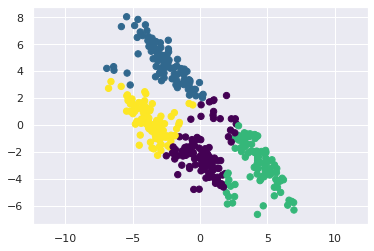

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit(X_stretched).predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='viridis');
ax = plt.gca()
ax.axis('equal')
plt.show();

Interesting. Because output cluster labels are forced to be circular, kmeans is picking up data points for different "true clusters". This can be fixed via EM using a GMM model.

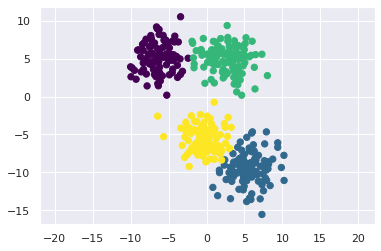

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4)
labels = gmm.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
ax = plt.gca()
ax.axis('equal')
plt.show();

Slightly better clustering results, especially at the border. EM does "soft" clustering, so we can actually examine each point's posterior probability.

In [8]:
probs = gmm.predict_proba(X)
print(probs[:10].round(3))

[[0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.996 0.    0.004]
 [0.    0.974 0.    0.026]
 [0.    0.999 0.    0.001]]


Let's now test it on the stretched dataset.

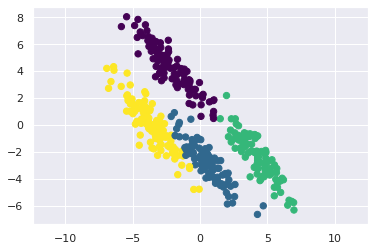

In [9]:
labels = gmm.fit(X_stretched).predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='viridis');
ax = plt.gca()
ax.axis('equal')
plt.show();

Nice! The clusters have been currently identified.

(This part is optional).
We can actually use GMM to fit lots of tiny clusters -- this helps us to model non-spherical/elliptical datasets too.

In [0]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

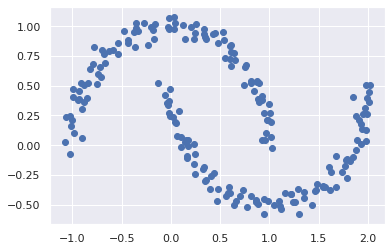

In [11]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

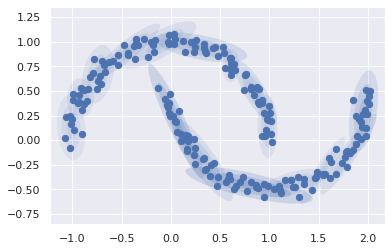

In [12]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

OK, let's do a real(istic) data experiment. Let's now use k-means to *automatically learn* MNIST digit classes without training labels. 

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [14]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

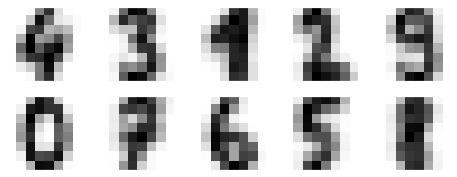

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Quite remarkably, the cluster centers recover the digits (without ever telling the algorithm what they are). The digit "8" is a bit blurred out though.

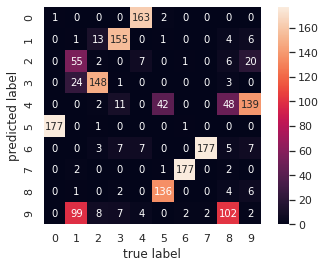

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, clusters)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', 
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Fairly accurate! We can compute accuracy by permuting the rows of the above matrix to match the max values of each row and column. 

In [17]:
from scipy.stats import mode
corrected_labels = np.zeros_like(clusters)
for i in range(10):
  mask = (clusters == i)
  corrected_labels[mask] = mode(digits.target[mask])[0]

from sklearn.metrics import accuracy_score
accuracy_score(digits.target, corrected_labels)

0.7952142459654981

Great! ~80% accuracy with no labels whatsoever! 

Actually -- if we do a bit more pre-processing, we can get even better results. There is a nonlinear dimensionality algorithm called (tSNE) which we don't discuss -- but which is very good at retaining "cluster" information. If we fit kmeans to a tSNE-reduced version of the dataset, we can improve performance all the way to 93% (which is even better than logistic regression/shallow neural nets) on MNIST. This example illustrates the power of unsupervised learning when used carefully.

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

accuracy_score(digits.target, labels)

0.9371174179187535